In [229]:
#importing necessary libraries
import pandas as pd
import glob
import os
import warnings
import time
import sys
import matplotlib.pyplot as plt
import seaborn as sns
# importing custom scripts for different functions
sys.path.append('scripts')  # add scripts to path




# Ignore warnings
warnings.filterwarnings("ignore")

In [230]:
data = pd.read_csv("combined.csv")
data.head()

,Commodity,Classification,Grade,Sex,Market,Wholesale,Retail,Supply Volume,County,Date
0,Banana (Ripening),-,-,-,Mukuyu Market,-,50.00/Kg,NaN,Muranga,2026-02-11
1,Banana (Ripening),-,-,-,Mulot,70.00/Kg,100.00/Kg,1500.0,Bomet,2026-02-11
2,Banana (Ripening),-,-,-,Kitale Municipality Market,80.00/Kg,100.00/Kg,6000.0,Trans-Nzoia,2026-02-11
3,Banana (Ripening),-,-,-,Kerugoya,20.00/Kg,40.00/Kg,300.0,Kirinyaga,2026-02-10
4,Banana (Ripening),-,-,-,Bondeni,80.00/Kg,100.00/Kg,5000.0,Trans-Nzoia,2026-02-10


In [231]:
data.isnull().sum()

Commodity             0
Classification        0
Grade                 0
Sex                   0
Market                0
Wholesale             0
Retail                0
Supply Volume     17775
County               19
Date                  0
dtype: int64

In [232]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57010 entries, 0 to 57009
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Commodity       57010 non-null  object 
 1   Classification  57010 non-null  object 
 2   Grade           57010 non-null  object 
 3   Sex             57010 non-null  object 
 4   Market          57010 non-null  object 
 5   Wholesale       57010 non-null  object 
 6   Retail          57010 non-null  object 
 7   Supply Volume   39235 non-null  float64
 8   County          56991 non-null  object 
 9   Date            57010 non-null  object 
dtypes: float64(1), object(9)
memory usage: 4.3+ MB


In [233]:
data.duplicated().sum()

4259

In [234]:
data.drop_duplicates(inplace=True)

In [235]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52751 entries, 0 to 57009
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Commodity       52751 non-null  object 
 1   Classification  52751 non-null  object 
 2   Grade           52751 non-null  object 
 3   Sex             52751 non-null  object 
 4   Market          52751 non-null  object 
 5   Wholesale       52751 non-null  object 
 6   Retail          52751 non-null  object 
 7   Supply Volume   36539 non-null  float64
 8   County          52743 non-null  object 
 9   Date            52751 non-null  object 
dtypes: float64(1), object(9)
memory usage: 4.4+ MB


In [236]:
data["County"]= data["County"].fillna((data["County"].mode()[0]))

In [237]:
# Filling NaNs using the median volume for each specific commodity
data['Supply Volume'] = data.groupby('Commodity')['Supply Volume'].transform(lambda x: x.fillna(x.median()))
data['Supply Volume'] = data['Supply Volume'].fillna(0)

In [238]:
data.isnull().sum()

Commodity         0
Classification    0
Grade             0
Sex               0
Market            0
Wholesale         0
Retail            0
Supply Volume     0
County            0
Date              0
dtype: int64

In [239]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52751 entries, 0 to 57009
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Commodity       52751 non-null  object 
 1   Classification  52751 non-null  object 
 2   Grade           52751 non-null  object 
 3   Sex             52751 non-null  object 
 4   Market          52751 non-null  object 
 5   Wholesale       52751 non-null  object 
 6   Retail          52751 non-null  object 
 7   Supply Volume   52751 non-null  float64
 8   County          52751 non-null  object 
 9   Date            52751 non-null  object 
dtypes: float64(1), object(9)
memory usage: 4.4+ MB


In [240]:
# changing the data types of the columns
data["Date"]= pd.to_datetime(data["Date"])
data["Wholesale"]= pd.to_numeric(data["Wholesale"].astype(str).str.replace('[^\d.]', '', regex=True), errors='coerce')
data["Retail"] = pd.to_numeric(data["Retail"].astype(str).str.replace('[^\d.]', '', regex=True), errors='coerce')
#data.info()

In [241]:
data= data.reset_index(drop=True) #

In [242]:
data= data.drop(columns=["Classification", "Grade", "Sex"])

In [243]:
data.describe()

,Wholesale,Retail,Supply Volume
count,41690.000000,50557.000000,5.275100e+04
mean,106.017020,154.883865,8.244659e+03
std,187.348026,401.865107,5.519642e+05
min,0.010000,0.010000,0.000000e+00
25%,40.000000,55.000000,6.000000e+02
50%,70.000000,100.000000,1.500000e+03
75%,120.000000,150.000000,3.500000e+03
max,14500.000000,22000.000000,1.000000e+08


In [244]:
# Calculate absolute price difference
data['Price_Margin'] = data['Retail'] - data['Wholesale']

# Calculate percentage margin
# (Retail - Wholesale) / Wholesale
#data['Margin_Percentage'] = (data['Price_Margin'] / data['Wholesale']) * 100

In [245]:
# Group by commodity to see average margins
profit_analysis = data.groupby('Commodity')['Price_Margin'].mean()

print("Top 5 Commodities by Price Margin:")
print(profit_analysis.head())

Top 5 Commodities by Price Margin:
Commodity
Banana (Cooking)               20.132585
Banana (Ripening)              19.877108
Beans (Yellow-Green)           64.122534
Beans Red Haricot (Wairimu)    61.569228
Cabbages                       12.945707
Name: Price_Margin, dtype: float64


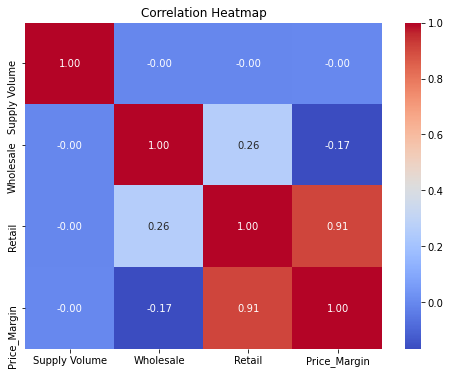

In [246]:
plt.figure(figsize=(8, 6))
correlation = data[['Supply Volume', 'Wholesale', 'Retail', 'Price_Margin']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [247]:
data.head()

,Commodity,Market,Wholesale,Retail,Supply Volume,County,Date,Price_Margin
0,Banana (Ripening),Mukuyu Market,NaN,50.0,1500.0,Muranga,2026-02-11,NaN
1,Banana (Ripening),Mulot,70.0,100.0,1500.0,Bomet,2026-02-11,30.0
2,Banana (Ripening),Kitale Municipality Market,80.0,100.0,6000.0,Trans-Nzoia,2026-02-11,20.0
3,Banana (Ripening),Kerugoya,20.0,40.0,300.0,Kirinyaga,2026-02-10,20.0
4,Banana (Ripening),Bondeni,80.0,100.0,5000.0,Trans-Nzoia,2026-02-10,20.0


In [248]:
data.isnull().sum()

Commodity            0
Market               0
Wholesale        11061
Retail            2194
Supply Volume        0
County               0
Date                 0
Price_Margin     13244
dtype: int64

In [249]:
# Sorting data by Date and Commodity
data = data.sort_values(['Commodity', 'Date'])

# Using linear interpolation to fill gaps in price trends
data['Retail'] = data.groupby('Commodity')['Retail'].transform(lambda x: x.interpolate(method='linear'))
data['Wholesale'] = data.groupby('Commodity')['Wholesale'].transform(lambda x: x.interpolate(method='linear'))

In [250]:
data['Price_Margin'] = data['Retail'] - data['Wholesale']
# data['Margin_Percentage'] = (data['Price_Margin'] / data['Wholesale']) * 100

In [251]:
# Calculate Coefficient of Variation - a measure of volatility
volatility = data.groupby('Commodity')['Retail'].std() / data.groupby('Commodity')['Retail'].mean()
print("Top 5 Most Volatile Commodities (Hardest to predict):")
print(volatility.sort_values(ascending=False).head())

Top 5 Most Volatile Commodities (Hardest to predict):
Commodity
Dry Maize                      3.217153
Banana (Cooking)               3.129433
Beans Red Haricot (Wairimu)    2.890531
Beans (Yellow-Green)           2.873962
Finger Millet                  2.421799
Name: Retail, dtype: float64


In [252]:
# Create a 7-day lag (Price for 1 week)
data['Retail_Lag_7'] = data.groupby(['Commodity', 'Market'])['Retail'].shift(7)

# Create a Rolling Mean (Average of the last 7 days)
data['Retail_Rolling_7'] = data.groupby(['Commodity', 'Market'])['Retail'].transform(lambda x: x.rolling(window=7).mean())

# Checking the correlation of the lag vs the actual price
correlation = data[['Retail', 'Retail_Lag_7']].corr().iloc[0,1]
print(f"Correlation within 1 week: {correlation:.2f}")

Correlation within 1 week: 0.30


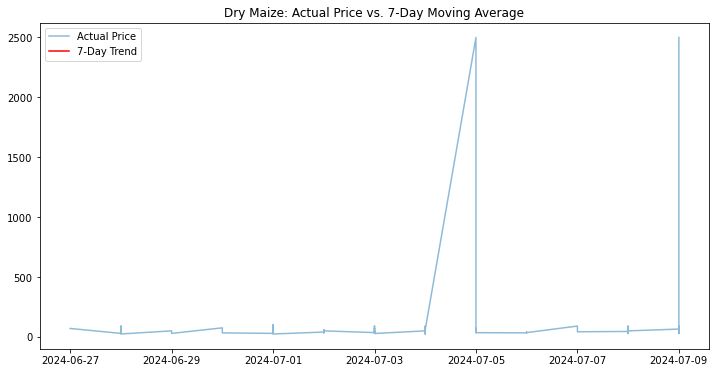

In [253]:
# Plotting the rolling mean against actual prices for a volatile commodity
maize_df = data[data['Commodity'] == 'Dry Maize'].head(100)

plt.figure(figsize=(12, 6))
plt.plot(maize_df['Date'], maize_df['Retail'], label='Actual Price', alpha=0.5)
plt.plot(maize_df['Date'], maize_df['Retail_Rolling_7'], label='7-Day Trend', color='red')
plt.title('Dry Maize: Actual Price vs. 7-Day Moving Average')
plt.legend()
plt.show()

In [254]:
# Check row counts per Market
market_counts = data['Market'].value_counts()
print("Top 5 Markets by Data Density:")
print(market_counts.head())

Top 5 Markets by Data Density:
Kitale Municipality Market    3121
Gikomba                       2883
Nairobi Supermarkets          2303
Kawangware                    1881
Ngurubani Market              1862
Name: Market, dtype: int64


In [255]:
# 2. Extracting the Month and creating the month column
data['Month'] = data['Date'].dt.month
seasonal_df = data.groupby(['Commodity', 'Month'])['Retail'].mean().reset_index()

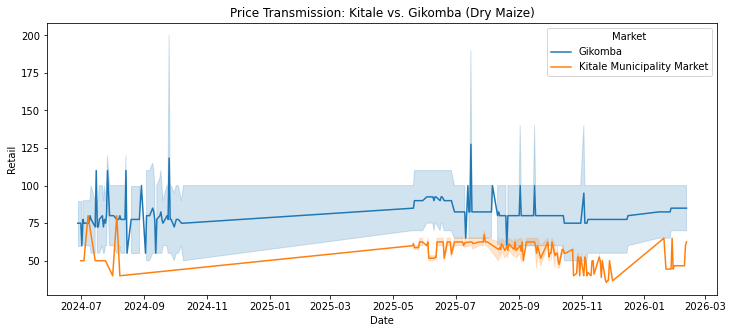

In [256]:
# Compare price movements between the production hub and consumption hub
hubs = data[data['Market'].isin(['Kitale Municipality Market', 'Gikomba'])]
plt.figure(figsize=(12, 5))
sns.lineplot(data=hubs[hubs['Commodity'] == 'Dry Maize'], x='Date', y='Retail', hue='Market')
plt.title('Price Transmission: Kitale vs. Gikomba (Dry Maize)')
plt.show()